In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
pd.set_option('display.max_columns', None)


#Graficos
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

#Metricas, Pipeline
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline

#Modelos
from sklearn import tree
from sklearn import linear_model
from sklearn import ensemble

# Abrindo o banco de dados / Limpando dados duplicados

In [2]:
df_stats = pd.read_csv('../New_csv/df_info_statsplayers')
df_medals = pd.read_csv('../New_csv/df_info_medalhas')
df_medals = df_medals.drop(columns='Unnamed: 0')
df_stats = df_stats.drop(columns='Unnamed: 0')
df_medals = df_medals.drop_duplicates()

- Juntando os dois dataframes com o parâmetro "how='outer'" o dataframe resultante terá dados preenchido com NaN
- Vou completar esses dados com 0, pois se tivermos dados vazio em jogos ou medalhas que dizer que o player não possui valor nesse campos, não é devido a falta de informação

In [3]:
df = pd.merge(df_stats, df_medals, on=['idPlayer','Data_Ref'], how='outer')
df = df.fillna(0)

Construindo uma função que recebe duas datas e cria uma lista como todas as datas entre data_inicial e data_final

In [4]:
def listar_dias(data_inicial, data_final):
    # Converter as strings de data em objetos datetime
    data_inicial = datetime.strptime(data_inicial, '%Y-%m-%d')
    data_final = datetime.strptime(data_final, '%Y-%m-%d')

    # Gerar a lista de dias entre as datas
    dias = []
    delta = timedelta(days=1)     
    while data_inicial <= data_final:
        dias.append(data_inicial.strftime('%Y-%m-%d'))
        data_inicial += delta

    return dias

data_inicial = '2021-10-14'
data_final = '2022-01-15'         #data_final = '2022-01-15'
dias = listar_dias(data_inicial,data_final)

# Construção da variável alvo

- Objetivo: Descobrir qual a probabilidade de um player que não é assinante se tornar assinante.

- Para isso, vou filtrar os dados para que tenha somente informação dos players que não tem assinatura ativa

In [5]:
df_ML = df[df['AssinaturaAtiva'] == 0.0]
df_ML['Alvo'] = 0

C:\Users\paulo\AppData\Local\Temp\ipykernel_18360\874572345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML['Alvo'] = 0


- Minha variável alvo é definida como ['alvo'] = 1 se o player tem uma assinatura que foi criada até 15 dias depois da Data_Ref

In [6]:
for dia_ref in dias:
    df_players_medals = pd.read_csv('../Original_csv/tb_players_medalha.csv')
    df_players_medals = df_players_medals[df_players_medals['dtCreatedAt'] < df_players_medals['dtExpiration']]
    df_players_medals['dtCreatedAt'] = pd.to_datetime(df_players_medals['dtCreatedAt'])
    df_players_medals = df_players_medals[df_players_medals['dtCreatedAt'] > dia_ref]
    df_players_medals = df_players_medals[df_players_medals['dtCreatedAt'] < pd.to_datetime(dia_ref) + pd.Timedelta(days=15)]
    df_players_medals['Alvo'] = 1
    df_alvo = df_players_medals[['idPlayer', 'Alvo']].drop_duplicates()
    df_alvo['Data_Ref'] = dia_ref

    df_ML = df_ML.set_index(['idPlayer', 'Data_Ref'])
    df_alvo = df_alvo.set_index(['idPlayer', 'Data_Ref'])
    df_ML.update(df_alvo)
    df_ML = df_ML.reset_index()

df_ML = df_ML.drop_duplicates(subset=['idPlayer', 'Data_Ref'])

Limpando alguns dados que me deram problemas

In [7]:
df_ML['qtRecencia'] = df_ML['qtRecencia'].str.replace(' days', '')
df_ML = df_ML.fillna(0)
df_ML.replace([np.inf, -np.inf], 1.10, inplace=True)   # KDA tive uma divisão por zero

# Modelos de Machine Learning

1. Definindo quais são as features é o alvo
2. Devidindo a base de dados em base de treino e de teste 

In [8]:
features = df_ML.columns[2:-2]
features = features.to_list()
target = 'Alvo'

X = df_ML[features]
y = df_ML[target]

X_train, X_test, y_train, y_test = model_selection.train_test_split(df_ML[features],df_ML[target], test_size= 0.2, random_state=42, stratify=df_ML[target]) 

# Testando alguns modelos e descobrir qual o melhor modelo base_line para posteriormente fazer otimização de parâmetros

In [20]:
# Definir o modelo e o pipeline

rf_clf = ensemble.RandomForestClassifier(random_state=42,n_jobs=-1, n_estimators=200, min_samples_leaf=20)

ada_clf = ensemble.AdaBoostClassifier(random_state=42,learning_rate= 0.8, n_estimators=200)

dt_clf = tree.DecisionTreeClassifier(random_state=42,max_depth=15, min_samples_leaf=50)

rl_clf = linear_model.LogisticRegressionCV(random_state=42, n_jobs=-1)


pipeline_rf = pipeline.Pipeline([
    ('model', rf_clf)
])

pipeline_ada = pipeline.Pipeline([
    ('model', ada_clf)
])

pipeline_dt = pipeline.Pipeline([
    ('model', dt_clf)
])

pipeline_rl = pipeline.Pipeline([
    ('model', rl_clf) 
])


# Lista com todos o modelos

models = {'Random_Florest':pipeline_rf, 
          'AdaBoost': pipeline_ada,
          'Decision Tree':pipeline_dt,
          'Logist Regression': pipeline_rl}

def train_test_report(model, X_train, y_train, X_test, y_test, key_metric, is_prob=True):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)
    metric_result = key_metric(y_test, prob[:,1]) if is_prob else key_metric(y_test, pred)

    return metric_result

In [21]:
for d,m in models.items():
    result = train_test_report(m, X_train, y_train, X_test, y_test, metrics.roc_auc_score)
    print(d, result)

Random_Florest 0.9798785084321016
AdaBoost 0.7879037450525473
Decision Tree 0.8907359921347168
Logist Regression 0.7549122390085344


c:\Users\paulo\OneDrive\Área de Trabalho\projetos\Predicao_assinaturas\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Resultado dos modelos usando poucos parâmetros tendo a curva ROC como métrica:

1. Random_Florest 0.9798785084321016
2. AdaBoost 0.7879037450525473
3. Decision Tree 0.8907359921347168
4. Logist Regression 0.7549122390085344

# Realizando a otimização de parâmetros usando GridSearch:

Agora eu quero que o grid search seja uma etapa do pipeline. Essa ordem é importante para economizar processamento. 
Então eu vou pegar o modelo que melhor desempenhou (random_florest) e fazer um pipeline para ele:

- Aqui eu coloco o grid dentro do pipeline, então meu fluxo de trabalho é:

1. Os dados passam por todas as modificações que eles precisam até estarem prontos para serem treinados
2. Os dados, agora pronto para serem treinados, passam pelo grid em que são treinados com diferentes parâmetros e é feito a comparação para eleger a melhor combinação

Desse modo eu não preciso processar os dados todas as vezes em que ele passar pelo grid com um parâmetro diferente

In [58]:
rf_clf = ensemble.RandomForestClassifier()
params = {"n_estimators":[50, 100, 150, 200],
          "min_samples_leaf":[1, 5, 10, 20] }

grid_search = model_selection.GridSearchCV(rf_clf, params, cv=4, scoring='roc_auc', verbose=3, refit=True)

pipe_rf = pipeline.Pipeline([("Modelo", grid_search)])  #Lembrar de fazer um pipeline completo depois

pipe_rf.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV 1/4] END min_samples_leaf=1, n_estimators=50;, score=0.990 total time=  11.7s
[CV 2/4] END min_samples_leaf=1, n_estimators=50;, score=0.989 total time=  11.7s
[CV 3/4] END min_samples_leaf=1, n_estimators=50;, score=0.987 total time=  11.8s
[CV 4/4] END min_samples_leaf=1, n_estimators=50;, score=0.990 total time=  12.0s
[CV 1/4] END min_samples_leaf=1, n_estimators=100;, score=0.990 total time=  23.3s
[CV 2/4] END min_samples_leaf=1, n_estimators=100;, score=0.990 total time=  23.5s
[CV 3/4] END min_samples_leaf=1, n_estimators=100;, score=0.987 total time=  23.4s
[CV 4/4] END min_samples_leaf=1, n_estimators=100;, score=0.991 total time=  23.2s
[CV 1/4] END min_samples_leaf=1, n_estimators=150;, score=0.990 total time=  34.8s
[CV 2/4] END min_samples_leaf=1, n_estimators=150;, score=0.990 total time=  35.5s
[CV 3/4] END min_samples_leaf=1, n_estimators=150;, score=0.988 total time=  35.7s
[CV 4/4] END min_samples_leaf=

Pipeline(steps=[('Modelo',
                 GridSearchCV(cv=4, estimator=RandomForestClassifier(),
                              param_grid={'min_samples_leaf': [1, 5, 10, 20],
                                          'n_estimators': [50, 100, 150, 200]},
                              scoring='roc_auc', verbose=3))])

Parâmetros dos melhores modelos foram salvos no csv Resultados_Modelos:
- O melhor conjunto é n_estimators 200 
- min_samples_leaf 1

Não trabalhei com outros parâmetros devido ao custo computacional. Com apenas esses parâmetros demorou 30 minutos para fazer o treinamento

Ordenei as features por ordem de importância e guardei os resultados no csv importance_var.csv

In [65]:
f_importance = pipe_rf[-1].best_estimator_.feature_importances_
df_importance_var_randomFlorest = pd.DataFrame(f_importance, index=features, columns=['importance']).sort_values(by='importance', ascending=False)
importancia_var = df_importance_var_randomFlorest
importancia_var

,importance
qtRecencia,0.050320
vlLevelAVG,0.025985
qtMedalhaDist,0.024152
HsHate,0.020645
qtShotsAVG,0.020607
...,...
qtPartidasMenos16,0.004936
qtWinsAnciente,0.004213
qtMedalhaAdquiridas,0.000514
qtPlusKillAVG,0.000000


# Métricas de Avaliação
- Baseline de Referência
Considerando um cenário de classificação desbalanceada, onde apenas 6.44% das observações no conjunto de teste representam a classe positiva (target=1), estabelecemos um baseline trivial:

Um modelo ingênuo que prevê todas as instâncias como classe negativa (target=0) teria uma acurácia esperada de 93.56% (100% - 6.44%).

O modelo Random Forest implementado apresentou os seguintes resultados:

| **Métrica**  | **Treino**  | **Teste**   | 
|:-------------|:-----------:|:-----------:|
| Acurácia     | 0.9971      | 0.9828      | 
| AUC-ROC      | 0.9992      | 0.9924      | 
| Ganho sobre baseline | 6.15% | 4.72% | 

Os resultados da curva são apresentados uma vez que escolhemos o modelo que apresentava a melhor pontuação nessa métrica.

In [77]:
y_train_pred = pipe_rf.predict(X_train)
y_train_prob = pipe_rf.predict_proba(X_train)
y_test_pred = pipe_rf.predict(X_test)
y_test_prob = pipe_rf.predict_proba(X_test)

print(f'Acurácia treino: {metrics.accuracy_score(y_train, y_train_pred):.4f}')
print(f'Acurácia teste: {metrics.accuracy_score(y_test, y_test_pred):.4f}')
print(f'AUC treino: {metrics.roc_auc_score(y_train, y_train_prob[:,1]):.4f}')
print(f'AUC teste: {metrics.roc_auc_score(y_test, y_test_prob[:,1]):.4f}')

# Distribuição das classes
print(f'Proporção de target=1 (treino): {y_train.mean():.2%}')
print(f'Proporção de target=1 (teste): {y_test.mean():.2%}')

Acurácia treino: 0.9971
Acurácia teste: 0.9828
AUC treino: 0.9992
AUC teste: 0.9924
Proporção de target=1 (treino): 6.45%
Proporção de target=1 (teste): 6.44%


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

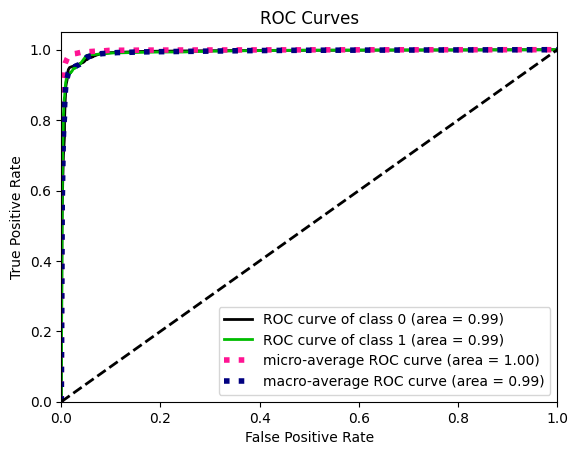

In [76]:
skplt.metrics.plot_roc(y_test, y_test_prob)

# KS Statistic Plot 
- KS Statistic (0.933)

É a máxima distância vertical entre as duas curvas cumulativas. Quanto maior esse valor (entre 0 e 1), melhor o modelo consegue diferenciar as classes.

- Threshold  (0.90)

A separação máxima ocorre quando você classifica como target=1 apenas os casos com probabilidade prevista ≥ 90%.

- Consequências:

Se escolher usar esse threshold, terá a máxima discriminação entre classes, mas isso pode levar a:

1. Alta precisão: Quase todos os classificados como target=1 serão verdadeiros positivos.

2. Posso obter assinantes reais (target=1) podem ser deixados de fora (falsos negativos).

KS Statistic Plot é um bom ponto de partida para avaliar o Threshold do modelo. Exemplo:

- Usar o threshold de 0.90 se a prioridade for evitar falsos positivos em campanhas de marketing com custo alto por pessoa.

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

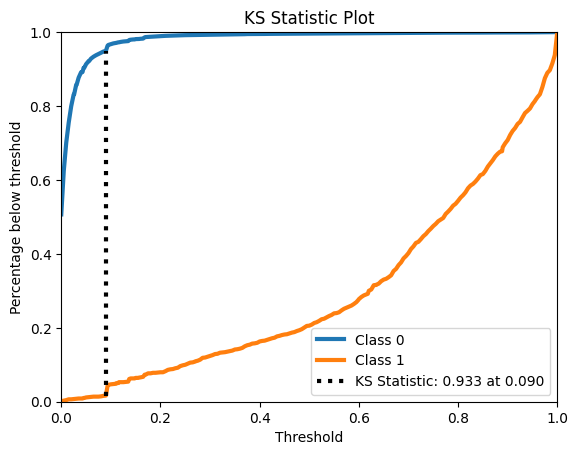

In [78]:
skplt.metrics.plot_ks_statistic(y_test,y_test_prob)

# Precision-Recall Plot

Com esse gráfico conseguimos ver a qualidade da previsões positivas (target=1|Precisão) e comparar com a capacidade de identificar todos os positivos para diferentes thresholds. Como temos desbalaceamento entre as váriaveis ela é uma métrica importante. 

- Class 0 (target=0): AUC = 0.999
Indica desempenho quase perfeito na identificação da classe majoritária (não assinantes). Entretanto esse valor já é esperado devido ao desbalancemento das variáveis, uma vez que temos 93% de target =0

- Class 1 (target=1): AUC = 0.919
Indica um bom desepenho para inditificação da classe minoritária (assinantes), mas ainda temos uma quantidade de falsos positivo ou falsos negativos. 

-  Micro-Average: AUC = 0.998
Reflete o desempenho global do modelo considerando ambas as classes juntas.

- Consequências:
1. Como temos uma boa identificação de não assinantes (target=0) o modelo se mostra excelente para minimizar custos operacionais em campanhas de retenção para clientes que não são assinantes.
2. Por outro lado, o modelo também é eficiente para identificar quais pessoas serão assinantes de modo que tem um bom poder preditivo de receitas. 

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

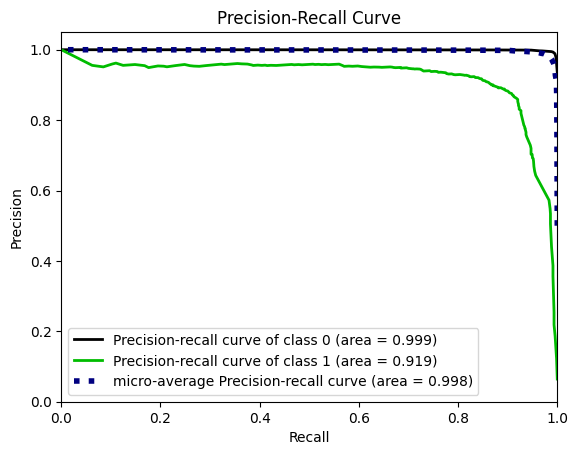

In [79]:
skplt.metrics.plot_precision_recall(y_test, y_test_prob)

 A curva de lift mostra quantas vezes o meu modelo é melhor do que um modelo aleatório 

### Interpretação dos Pontos da Curva de Lift 

| **x (População)** | **y (Lift)** | **Significado**                                                                 |
|--------------------|--------------|---------------------------------------------------------------------------------|
| 0.05 (5%)          | 13           | Nos 5% mais propensos a assinar (segundo o modelo), há **13x mais assinantes** que a média. |
| 0.10 (10%)         | 9.8          | Nos 10% mais propensos, há **9.8x mais assinantes** que a média.               |
| 0.20 (20%)         | 5            | Nos 20% mais propensos, há **5x mais assinantes** que a média.                 |
| 0.40 (40%)         | 2.2          | Nos 40% mais propensos, há **2.2x mais assinantes** que a média.               |
| 0.60 (60%)         | 1.8          | Nos 60% mais propensos, há **1.8x mais assinantes** que a média.               |

Com esses dados podemos avaliar o custo/resultado de uma campanha direcionada em relação a uma proporção do público

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

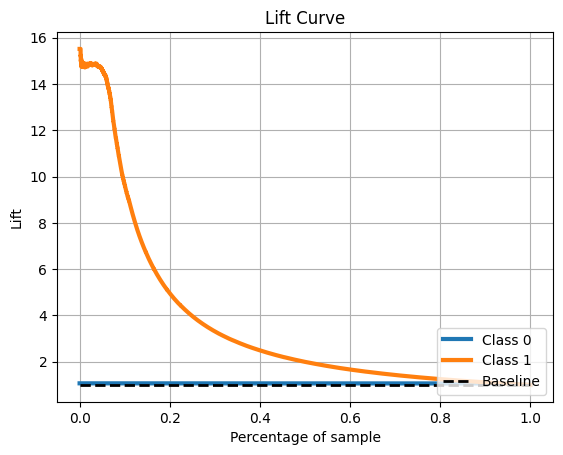

In [80]:
skplt.metrics.plot_lift_curve(y_test,y_test_prob)

# Matriz de confusão: 

### Legenda da Matriz de Confusão

|                     | **Previsto Não-Assinante (0)** | **Previsto Assinante (1)** |
|---------------------|-------------------------------|---------------------------|
| **Real Não-Assinante (0)** | 19.949 (TN)                  | 84 (FP)                   |
| **Real Assinante (1)**    | 284 (FN)                     | 1.096 (TP)                |

*(TN = Verdadeiro Negativo, FP = Falso Positivo, FN = Falso Negativo, TP = Verdadeiro Positivo)*

Um ponto de atenção são os falsos negativos. Apesar de ser um valor pequeno (284) em relação aos verdadeiros positivos (19949), entender o perfil dessas pessoas é uma bota rota para melhorar o modelo

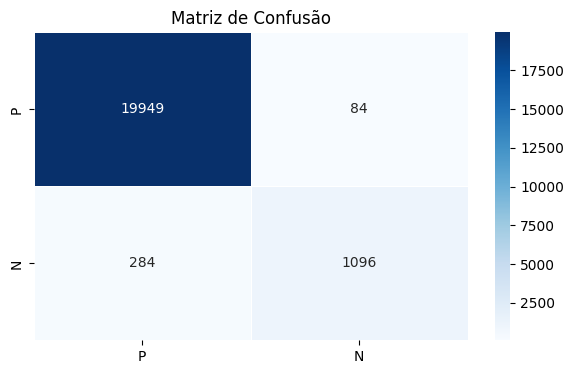

In [92]:
# Calcular a matriz de confusão
nb_conf = metrics.confusion_matrix(y_test, y_test_pred)

# Criar um DataFrame a partir da matriz de confusão
conf_df = pd.DataFrame(nb_conf, index=['P', 'N'], columns=['P', 'N'])

# Plotar a matriz de confusão
plt.figure(figsize=(7, 4))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.title('Matriz de Confusão')
plt.show()